<a href="https://colab.research.google.com/github/shresth26/S-MART/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder, RobustScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pandas_datareader import data, wb
import datetime
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

## Loading Data

In [2]:
tender = pd.read_csv('tender.csv')
products = pd.read_csv('products.csv')

In [3]:
products.head()

,customerID,DOB,Gender,State,PinCode,transactionDate,store_code,store_description,till_no,transaction_number_by_till,promo_code,promotion_description,product_code,product_description,sale_price_after_promo,discountUsed
0,BBID_20482,1975-10-20,male,MADHYA PRADESH,453441.0,2016-05-01,2655,BB-INDORE-MALHAR MEGA MALL,2,85246,NONPROMO,NaN,1000446431,PATANJALI CHOCOS 125g,55.00,Payback
1,BBID_20485,1955-07-21,female,NaN,999999.0,2017-03-09,2655,BB-INDORE-MALHAR MEGA MALL,8,78829,NONPROMO,NaN,1000010431,SOO FRESH ROLLS HOT DOG 4P,30.00,Payback
2,BBID_20498,1981-03-19,female,MAHARASHTRA,400064.0,2015-08-12,2655,BB-INDORE-MALHAR MEGA MALL,13,1064,0000971754,AD 399 FLAT LADIES JEANS FASHION EXC,1000077851005,"DLJ-0010-BSF-2-CJ-FL, 34, BLACK",418.95,Payback
3,BBID_20499,1986-05-10,male,MAHARASHTRA,400099.0,2016-12-18,2615,BB-AMRITSAR-TRILIUM MALL,14,51080,NONPROMO,NaN,1000443231,PATANJALI TOMATO KETCHUP BT 500g,70.00,Payback
4,BBID_204110,1988-02-29,male,MADHYA PRADESH,474001.0,2015-12-31,2655,BB-INDORE-MALHAR MEGA MALL,9,21911,0000974126,NMP 5% OFF CONCEPT DISCOUNT 2655,300481741,MAGGI NDL MERI MASALA PP 70g,34.20,Payback


In [4]:
tender.head()

,customerID,DOB,Gender,State,PinCode,transactionDate,store_code,store_description,till_no,tender_type,transaction_number_by_till,payment_amount_by_tender,PaymentUsed
0,BBID_2044,1984-04-02,male,NaN,626125.0,2015-09-03,4986,BB-MADURAI-KOCHADAI VILLAGE,22,GVOWN,9208,1000.00,GiftVoucher
1,BBID_2044,1984-04-02,male,NaN,626125.0,2015-09-03,4986,BB-MADURAI-KOCHADAI VILLAGE,22,CASH,9208,10.46,CASH
2,BBID_2044,1984-04-02,male,NaN,626125.0,2016-04-17,4986,BB-MADURAI-KOCHADAI VILLAGE,19,EDCAXIS,90269,677.28,AXIS
3,BBID_2044,1984-04-02,male,NaN,626125.0,2016-04-17,4986,BB-MADURAI-KOCHADAI VILLAGE,19,MOBI,90268,1042.00,One MobiKwik Systems
4,BBID_2044,1984-04-02,male,NaN,626125.0,2016-04-17,4986,BB-MADURAI-KOCHADAI VILLAGE,19,MOBI,90269,1000.00,One MobiKwik Systems


### Handling Missing values

In [5]:
products['promotion_description'].fillna('no_promo', inplace=True)
products['Gender'].fillna('no_gender', inplace=True)
products['State'].fillna('no_state', inplace=True)
products['PinCode'].fillna(-1, inplace=True)
products['DOB'].fillna("1", inplace=True)

### Converting data into numeric / float

In [6]:
for c in products.columns:
    lbl = LabelEncoder()
    if products[c].dtype == 'object' and c not in ['store_description','customerID','transactionDate']:
        products[c] = lbl.fit_transform(products[c])

In [7]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11972 entries, 0 to 11971
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerID                  11972 non-null  object 
 1   DOB                         11972 non-null  int64  
 2   Gender                      11972 non-null  int64  
 3   State                       11972 non-null  int64  
 4   PinCode                     11972 non-null  float64
 5   transactionDate             11972 non-null  object 
 6   store_code                  11972 non-null  int64  
 7   store_description           11972 non-null  object 
 8   till_no                     11972 non-null  int64  
 9   transaction_number_by_till  11972 non-null  int64  
 10  promo_code                  11972 non-null  int64  
 11  promotion_description       11972 non-null  int64  
 12  product_code                11972 non-null  int64  
 13  product_description         119

In [8]:
products.head(2)

,customerID,DOB,Gender,State,PinCode,transactionDate,store_code,store_description,till_no,transaction_number_by_till,promo_code,promotion_description,product_code,product_description,sale_price_after_promo,discountUsed
0,BBID_20482,3108,1,20,453441.0,2016-05-01,2655,BB-INDORE-MALHAR MEGA MALL,2,85246,2213,2010,1000446431,4269,55.0,24
1,BBID_20485,594,0,36,999999.0,2017-03-09,2655,BB-INDORE-MALHAR MEGA MALL,8,78829,2213,2010,1000010431,5121,30.0,24


In [9]:
by_store_desc = products.groupby("store_description")
by_store_desc.mean()

,DOB,Gender,State,PinCode,store_code,till_no,transaction_number_by_till,promo_code,promotion_description,product_code,product_description,sale_price_after_promo,discountUsed
store_description,,,,,,,,,,,,,
BB-AMRITSAR-TRILIUM MALL,3285.408022,0.854772,26.349931,156611.124481,2615.0,8.968188,49042.356846,1882.461964,1458.235131,1.140550e+11,2847.396957,186.455380,8.290456
BB-HUBLI-GOKUL ROAD-AKSHAY CEN,2943.606575,0.914379,19.336705,532821.248916,4796.0,10.396676,48774.490968,1913.524205,1707.052384,9.096180e+10,3025.423410,150.773916,22.810332
BB-INDORE-MALHAR MEGA MALL,3967.847488,0.812794,22.549693,452809.792917,2655.0,7.179256,44456.108782,1964.325623,1779.710878,7.976166e+10,2929.641850,133.752280,18.117456
BB-INDORE-TREASURE ISLAND,4150.093079,0.735084,22.052506,473512.361177,2906.0,8.151949,36687.421639,2027.683373,1784.295147,1.386935e+11,2901.189340,139.138043,20.318218
BB-JAMSHEDPUR-NH-33,3477.519906,0.863232,18.256674,759948.907728,4843.0,10.494145,51589.503981,1837.851522,1605.162061,7.954487e+10,2849.703513,151.799522,23.189227
BB-LUDHIANA-FEROZEPUR-MF,3770.128920,0.860627,25.757840,151556.721254,3692.0,5.205575,50358.003484,1902.461672,1408.918118,1.050238e+11,2826.041812,158.998798,12.562718
BB-MADURAI-KOCHADAI VILLAGE,3326.441648,0.794050,29.400458,572335.250000,4986.0,13.080092,52882.939931,1892.247140,1764.308352,8.145967e+10,2775.545767,141.628381,22.613272


In [10]:
df = products 
df['transactionDate'] = pd.to_datetime(df['transactionDate'])

In [11]:
type(df['transactionDate'].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [12]:
if(df['customerID'].iloc[0].split('_')[0] != 'BBID'):
    df['customerID'] = df['customerID'].apply(lambda bbid: "BBID_"+bbid)

In [13]:
stores = list(set(df['store_code']))

cluster_labels = []
cluster_store = []
cluster_data = []
cluster_customers = []
cluster_score = []

for x in stores:
    cld = df[df['store_code'] == x]
    cluster_customers.append(cld['customerID'])
    cld.drop(['store_code','customerID','transactionDate','store_description'], axis=1, inplace=True)
    
    rbs = RobustScaler()
    cld2 = rbs.fit_transform(cld)
    
    km1 = KMeans(n_clusters=6)
    km2 = km1.fit(cld2)
    label = km2.predict(cld2)
    
    s_score = silhouette_score(cld2, label)
    cluster_score.append(s_score)
    
    cluster_labels.append(label)
    cluster_store.append(np.repeat(x, cld.shape[0]))
    cluster_data.append(cld2)

In [14]:
## merge list into ndarray
cluster_data = np.concatenate(cluster_data)
## convert nested lists as 1d array
cluster_customers = np.concatenate(cluster_customers)
cluster_store = np.concatenate(cluster_store)
cluster_labels = np.concatenate(cluster_labels)

### Creating submission files

In [15]:
sub1 = pd.DataFrame({'customerID':cluster_customers, 'store_code':cluster_store, 'cluster':cluster_labels})

In [16]:
np.savetxt('subOne_18.txt', cluster_data)
sub1.to_csv('subtwo_18.csv', index=False)

In [17]:
cluster_customers_number = []
for x in cluster_customers:
    cluster_customers_number.append(x.split('_')[1])
cluster_customers_number = np.array(cluster_customers_number)

In [18]:
df['customerID'] = df['customerID'].apply(lambda num: num.split('_')[1])

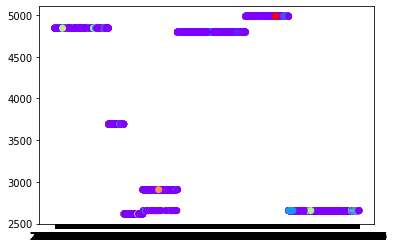

In [19]:
plt.scatter(cluster_customers_number,cluster_store,c=cluster_labels,cmap='rainbow')

In [20]:
def converter(store_desc):
    if store_desc=='BB-AMRITSAR-TRILIUM MALL':
        return 1
    elif store_desc=='BB-HUBLI-GOKUL ROAD-AKSHAY CEN':
        return 2
    elif store_desc=='BB-INDORE-MALHAR MEGA MALL':
        return 3
    elif store_desc=='BB-INDORE-TREASURE ISLAND':
        return 4
    elif store_desc=='BB-JAMSHEDPUR-NH-33':
        return 5
    elif store_desc=='BB-LUDHIANA-FEROZEPUR-MF':
        return 6
    elif store_desc=='BB-MADURAI-KOCHADAI VILLAGE':
        return 7
    else:
        return 8

df['store_description_no'] = df['store_description'].apply(converter) 

In [21]:
df.drop('store_description',axis=1,inplace=True)

In [22]:
df.head(2)

,customerID,DOB,Gender,State,PinCode,transactionDate,store_code,till_no,transaction_number_by_till,promo_code,promotion_description,product_code,product_description,sale_price_after_promo,discountUsed,store_description_no
0,20482,3108,1,20,453441.0,2016-05-01,2655,2,85246,2213,2010,1000446431,4269,55.0,24,3
1,20485,594,0,36,999999.0,2017-03-09,2655,8,78829,2213,2010,1000010431,5121,30.0,24,3


In [23]:
df['transactionDate'].iloc[0].month

5

In [24]:
years = []
months = []
weekdays = []
for x in df['transactionDate']:
    years.append(x.year)
for x in df['transactionDate']:
    months.append(x.month)
for x in df['transactionDate']:
    weekdays.append(x.weekday())
df['Year'] = np.array(years)
df['Month'] = np.array(months)
df['Weekday'] = np.array(weekdays)

In [25]:
df.head(2)

,customerID,DOB,Gender,State,PinCode,transactionDate,store_code,till_no,transaction_number_by_till,promo_code,promotion_description,product_code,product_description,sale_price_after_promo,discountUsed,store_description_no,Year,Month,Weekday
0,20482,3108,1,20,453441.0,2016-05-01,2655,2,85246,2213,2010,1000446431,4269,55.0,24,3,2016,5,6
1,20485,594,0,36,999999.0,2017-03-09,2655,8,78829,2213,2010,1000010431,5121,30.0,24,3,2017,3,3


In [26]:
stores = list(set(df['store_code']))

cluster_labels = []
cluster_store = []
cluster_data = []
cluster_customers = []
cluster_score = []

for x in stores:
    cld = df[df['store_code'] == x]
    cluster_customers.append(cld['customerID'])
    cld.drop(['store_code','customerID','transactionDate','Year','promotion_description','Month','store_description_no'], axis=1, inplace=True)
    
    rbs = RobustScaler()
    cld2 = rbs.fit_transform(cld)
    
    km1 = KMeans(n_clusters=3)
    km2 = km1.fit(cld2)
    label = km2.predict(cld2)
    
    s_score = silhouette_score(cld2, label)
    cluster_score.append(s_score)
    
    cluster_labels.append(label)
    cluster_store.append(np.repeat(x, cld.shape[0]))
    cluster_data.append(cld2)

## merge list into ndarray
cluster_data = np.concatenate(cluster_data)
## convert nested lists as 1d array
cluster_customers = np.concatenate(cluster_customers)
cluster_store = np.concatenate(cluster_store)
cluster_labels = np.concatenate(cluster_labels)

## create submission files
sub1 = pd.DataFrame({'customerID':"BBID_"+cluster_customers, 'store_code':cluster_store, 'cluster':cluster_labels})

np.savetxt('subOne_18.txt', cluster_data)
sub1.to_csv('subtwo_18.csv', index=False)

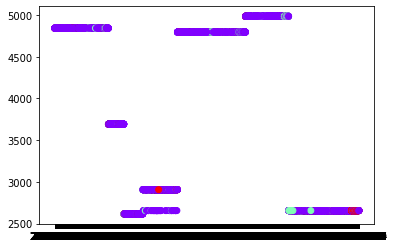

In [27]:
plt.scatter(cluster_customers_number,cluster_store,c=cluster_labels,cmap='rainbow')

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



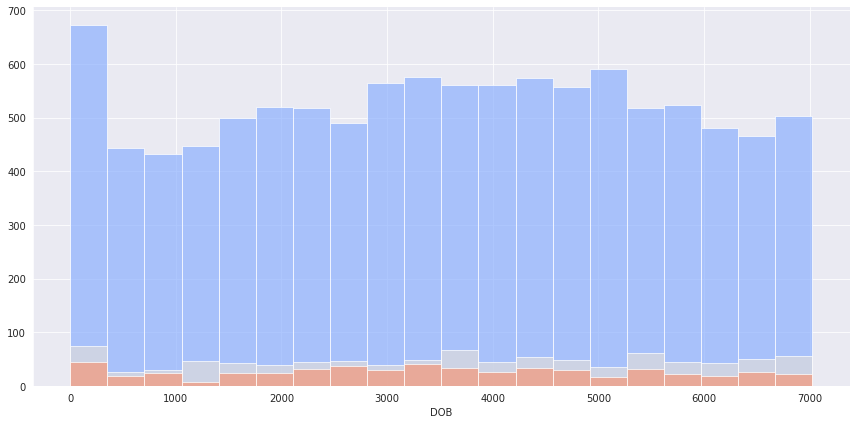

In [28]:
df_clusters = pd.DataFrame()
df_clusters['Cluster'] = np.array(cluster_labels)
df_clusters['DOB'] = df['DOB']
df_clusters['store_code'] = df['store_code']
df_clusters['State'] = df['State']
# df_clusters
sns.set_style('darkgrid')
g = sns.FacetGrid(df_clusters,hue="Cluster",palette='coolwarm',size=6,aspect=2)
g = g.map(plt.hist,'DOB',bins=20,alpha=0.7)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:580: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



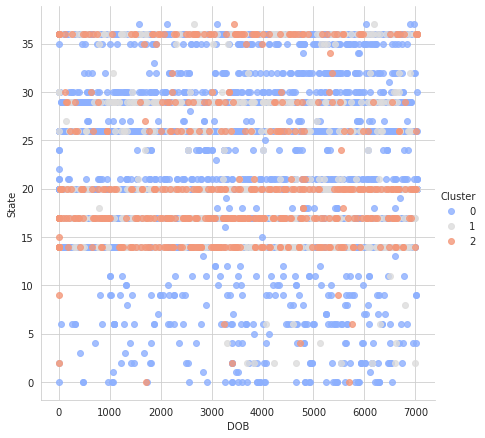

In [29]:
sns.set_style('whitegrid')
sns.lmplot('DOB','State',data=df_clusters, hue='Cluster',
           palette='coolwarm',size=6,aspect=1,fit_reg=False)

In [30]:
df1 = tender

In [31]:
df1.head()

,customerID,DOB,Gender,State,PinCode,transactionDate,store_code,store_description,till_no,tender_type,transaction_number_by_till,payment_amount_by_tender,PaymentUsed
0,BBID_2044,1984-04-02,male,NaN,626125.0,2015-09-03,4986,BB-MADURAI-KOCHADAI VILLAGE,22,GVOWN,9208,1000.00,GiftVoucher
1,BBID_2044,1984-04-02,male,NaN,626125.0,2015-09-03,4986,BB-MADURAI-KOCHADAI VILLAGE,22,CASH,9208,10.46,CASH
2,BBID_2044,1984-04-02,male,NaN,626125.0,2016-04-17,4986,BB-MADURAI-KOCHADAI VILLAGE,19,EDCAXIS,90269,677.28,AXIS
3,BBID_2044,1984-04-02,male,NaN,626125.0,2016-04-17,4986,BB-MADURAI-KOCHADAI VILLAGE,19,MOBI,90268,1042.00,One MobiKwik Systems
4,BBID_2044,1984-04-02,male,NaN,626125.0,2016-04-17,4986,BB-MADURAI-KOCHADAI VILLAGE,19,MOBI,90269,1000.00,One MobiKwik Systems


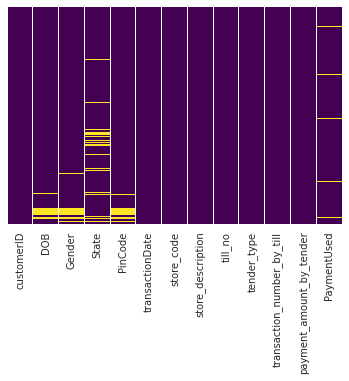

In [32]:
sns.heatmap(df1.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [33]:
df1['PaymentUsed'].fillna('no_pay', inplace=True)
df1['Gender'].fillna('no_gender', inplace=True)
df1['State'].fillna('no_state', inplace=True)
df1['PinCode'].fillna(-1, inplace=True)
df1['DOB'].fillna("1", inplace=True)

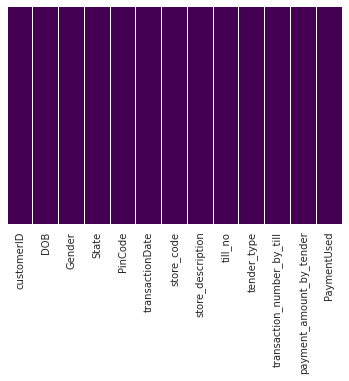

In [34]:
sns.heatmap(df1.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [35]:
df1.describe()

,PinCode,store_code,till_no,transaction_number_by_till,payment_amount_by_tender
count,149752.000000,149752.000000,149752.000000,1.497520e+05,149752.000000
mean,527931.008848,4092.197707,9.699176,4.237656e+05,1515.504483
std,221985.625616,1015.442506,5.908312,5.135921e+07,2032.301453
min,-1.000000,2615.000000,1.000000,2.000000e+00,-28990.000000
25%,452001.000000,2655.000000,5.000000,2.365475e+04,299.000000
50%,580024.000000,4796.000000,9.000000,4.817500e+04,835.815000
75%,625016.000000,4843.000000,14.000000,7.249975e+04,2004.000000
max,999999.000000,4986.000000,25.000000,7.031894e+09,65635.400000


In [36]:
by_cust_id = df1.groupby("customerID")
by_cust_id.mean().head(2)

,PinCode,store_code,till_no,transaction_number_by_till,payment_amount_by_tender
customerID,,,,,
BBID_204100102,456010.0,2702.0625,9.062500,33217.312500,1301.270000
BBID_204100150,625016.0,4986.0000,10.788462,54183.019231,334.425577


In [38]:
df1_wo_bbid = df1
payment_mode = df1_wo_bbid['PaymentUsed'].value_counts()
payment_mode = payment_mode.index.tolist()
payment_mode = {k: v for v, k in enumerate(payment_mode)}
payment_mode
def payment_converter(pay_mode):
    return payment_mode[pay_mode]

df1_wo_bbid['PayUsedCode'] = df1_wo_bbid['PaymentUsed'].apply(payment_converter)

In [39]:
df1_wo_bbid.head(2)

,customerID,DOB,Gender,State,PinCode,transactionDate,store_code,store_description,till_no,tender_type,transaction_number_by_till,payment_amount_by_tender,PaymentUsed,PayUsedCode
0,BBID_2044,1984-04-02,male,no_state,626125.0,2015-09-03,4986,BB-MADURAI-KOCHADAI VILLAGE,22,GVOWN,9208,1000.00,GiftVoucher,10
1,BBID_2044,1984-04-02,male,no_state,626125.0,2015-09-03,4986,BB-MADURAI-KOCHADAI VILLAGE,22,CASH,9208,10.46,CASH,0


In [40]:
by_cust_id = df1_wo_bbid.groupby("customerID")
by_cust_id = by_cust_id.mean().reset_index()
df_df1_merged = pd.merge(by_cust_id,df,how='outer',on='customerID')
df_df1_merged['PinCode_x'] = df_df1_merged['PinCode_x'].fillna(value=df_df1_merged['PinCode_x'].mean())
df_df1_merged['store_code_x'] = df_df1_merged['store_code_x'].fillna(value=df_df1_merged['store_code_x'].value_counts().idxmax()).astype(int)
df_df1_merged['till_no_x'] = df_df1_merged['till_no_x'].fillna(value=df_df1_merged['till_no_x'].value_counts().idxmax()).astype(int)
df_df1_merged['transaction_number_by_till_x'] = df_df1_merged['transaction_number_by_till_x'].fillna(value=df_df1_merged['transaction_number_by_till_x'].value_counts().idxmax()).astype(int)
df_df1_merged['payment_amount_by_tender'] = df_df1_merged['payment_amount_by_tender'].fillna(value=df_df1_merged['payment_amount_by_tender'].sum())
df_df1_merged['PayUsedCode'] = df_df1_merged['PayUsedCode'].fillna(value=0)
# df_df1_merged['PinCode_x']
df_df1_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21352 entries, 0 to 21351
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   customerID                    21352 non-null  object        
 1   PinCode_x                     21352 non-null  float64       
 2   store_code_x                  21352 non-null  int64         
 3   till_no_x                     21352 non-null  int64         
 4   transaction_number_by_till_x  21352 non-null  int64         
 5   payment_amount_by_tender      21352 non-null  float64       
 6   PayUsedCode                   21352 non-null  float64       
 7   DOB                           11972 non-null  float64       
 8   Gender                        11972 non-null  float64       
 9   State                         11972 non-null  float64       
 10  PinCode_y                     11972 non-null  float64       
 11  transactionDate             